<a href="https://colab.research.google.com/github/jeverding/TensorFlow-Distributed-Deep-Learning/blob/notebook-edits/Distributed_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Distributed Computing with TensorFlow

This code implements a number of different distributed computing strategies using TensorFlow 2 and the Keras API. Concerning benchmarking, the performance of the strategies is briefly compared eventually. 

The underlying data is from the [MNIST database](https://https://www.tensorflow.org/datasets/catalog/mnist), which includes 70,000 observations of handwritten digits. 
The main reason for using the MNIST data is that it is one of the most famous datasets in the area of computer vision and has been widely used for benchmarking. Note, however, that it may not be the ideal dataset for comparing the performance of Tensor Processing Units (TPUs) with Graphics Processing Units (GPUs) given the size of the data, for instance. 

Moreover, the distribution strategies require different processing units so the code must be executed in chunks on different machines (e.g. GPU or TPU based). 

Presented in slightly different format as part of the GSERM Deep Learning course on 10 Jan. 2020 by Kevin Koch and Jakob Everding. 

## Setup

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Reshape
import os
import matplotlib.pyplot as plt
import time

TensorFlow 2.x selected.


## List processing units 

Returns details on the available (traditional) processing units, i.e. CPUs and GPUs.

In [3]:
list_cpus = tf.config.experimental.list_physical_devices('CPU')
print("Num CPUs Available: ", len(list_cpus))
print("CPUs Available: ", list_cpus)

list_gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(list_gpus))
print("GPUs Available: ", list_gpus)

Num CPUs Available:  1
CPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi # more detailed information on NVIDA graphics card 

Sat Jan 11 16:42:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Check if TPU is available and if yes, return detailed information.

Before running this code, ensure that TPU is selected as hardware accelerator via *Runtime -> Change Runtime*.

As of 11 Jan. 2020, Google provides one TPU with 8 cores in Colab.

In [0]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  
  print('Found TPU at: {}'.format(TPU_ADDRESS))

  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.39.0.114:8470


INFO:tensorflow:Initializing the TPU system: 10.39.0.114:8470


INFO:tensorflow:Initializing the TPU system: 10.39.0.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## MNIST data
Load the [MNIST dataset](https://https://www.tensorflow.org/datasets/catalog/mnist) from TF/Keras. 

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Simple data pre-processing 
Includes rescaling grayscale images (0 to 1) and one-hot encoding. 

The data pipeline further includes shuffling and batching the data. 

In [6]:
x_train = tf.cast(x_train, tf.float32)/255.
x_test = tf.cast(x_test, tf.float32)/255.
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

input_shape = (x_train.shape[1], x_train.shape[2])

print('x_train shape:', x_train.shape)
print('Train samples:', x_train.shape[0])
print('Test samples:', x_test.shape[0])
print('Input_shape:', input_shape)

x_train shape: (60000, 28, 28)
Train samples: 60000
Test samples: 10000
Input_shape: (28, 28)


In [0]:
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache().shuffle(1000).repeat().batch(1024, drop_remainder=True).prefetch(-1)
test_batches = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache().shuffle(1000).repeat().batch(1024, drop_remainder=True).prefetch(-1)

Note that the TPU distribution strategy requires a specific batch size (see e.g. [link](https://https://cloud.google.com/tpu/docs/training-on-tpu-pods)). 

In order to use the full power of the TPU, set the batch size to a multiple of 128 since each TPU can do 128 computations in parallel by design. Furthermore, the number of steps must be set so that the model can allocate the data correctly.

In [0]:
BATCH_SIZE = 1024 # multiple of 128 to optimize TPU usage (8 cores x 128 -> 1024)

STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_test.shape[0] // BATCH_SIZE

## Build CNN model 
The simple model utilizes [batchnorm](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) for the convolutional layers as well as [dropout](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout?version=stable) for the dense layers.

To run the model with each distribution strategy, we create functions which later take care of model building and fitting.

In [0]:
def create_model():
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28,28), target_shape=(28, 28, 1), name="image"),

        tf.keras.layers.Conv2D(filters=12, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=32, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.4), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Code up additional helper functions to plot results, runtime, and fit model. 

In [0]:
timings = dict() # used to store total run time of each model

def create_accuracy_and_loss_graph(history, model_name):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('{} {}'.format(model_name, '- Accuracy'))

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,1.0])
  plt.title('{} {}'.format(model_name, '- Loss'))
  plt.xlabel('epoch')
  plt.show()

def fit_model_and_plot(model, train_batches, test_batches, steps_per_epoch, validation_steps, model_name, epochs=10):
  start_time = time.time()
  history = model.fit(
    train_batches,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_batches,
    validation_steps=validation_steps
  )
  run_time = time.time() - start_time
  timings[model_name] = run_time
  print()
  print("--- {} seconds for all {} epochs ---".format(run_time, epochs))
  print()

  create_accuracy_and_loss_graph(history, model_name)

## Implement distribution strategies

### Reference strategy
This model uses TensorFlows default computational settings and no user-specific distribution strategy. 

Train for 58 steps, validate for 9 steps
Epoch 1/10
58/58 [==============================] - 9s 148ms/step - loss: 0.3511 - accuracy: 0.8960 - val_loss: 1.5868 - val_accuracy: 0.4657
Epoch 2/10
58/58 [==============================] - 7s 128ms/step - loss: 0.0856 - accuracy: 0.9772 - val_loss: 1.6297 - val_accuracy: 0.4821
Epoch 3/10
58/58 [==============================] - 8s 130ms/step - loss: 0.0551 - accuracy: 0.9853 - val_loss: 1.3457 - val_accuracy: 0.5630
Epoch 4/10
58/58 [==============================] - 8s 130ms/step - loss: 0.0401 - accuracy: 0.9896 - val_loss: 0.9351 - val_accuracy: 0.6640
Epoch 5/10
58/58 [==============================] - 8s 130ms/step - loss: 0.0307 - accuracy: 0.9918 - val_loss: 0.4854 - val_accuracy: 0.8343
Epoch 6/10
58/58 [==============================] - 8s 131ms/step - loss: 0.0248 - accuracy: 0.9938 - val_loss: 0.1934 - val_accuracy: 0.9457
Epoch 7/10
58/58 [==============================] - 7s 129ms/step - loss: 0.0202 - accuracy: 0.9948 - val_l

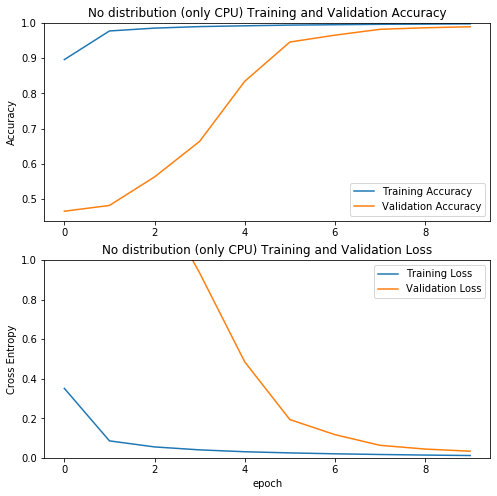

In [0]:
# Base model normally uses CPU (except a GPU is available)
base_model = create_model()

fit_model_and_plot(base_model, train_batches, test_batches, STEPS_PER_EPOCH, VALIDATION_STEPS, "No distribution (only CPU)")

Train for 58 steps, validate for 9 steps
Epoch 1/10
58/58 [==============================] - 2s 36ms/step - loss: 0.3611 - accuracy: 0.8906 - val_loss: 1.3733 - val_accuracy: 0.7093
Epoch 2/10
58/58 [==============================] - 1s 21ms/step - loss: 0.0964 - accuracy: 0.9734 - val_loss: 1.1827 - val_accuracy: 0.6641
Epoch 3/10
58/58 [==============================] - 1s 20ms/step - loss: 0.0597 - accuracy: 0.9840 - val_loss: 0.7904 - val_accuracy: 0.8075
Epoch 4/10
58/58 [==============================] - 1s 20ms/step - loss: 0.0432 - accuracy: 0.9884 - val_loss: 0.4466 - val_accuracy: 0.9221
Epoch 5/10
58/58 [==============================] - 1s 20ms/step - loss: 0.0338 - accuracy: 0.9911 - val_loss: 0.1987 - val_accuracy: 0.9667
Epoch 6/10
58/58 [==============================] - 1s 20ms/step - loss: 0.0257 - accuracy: 0.9932 - val_loss: 0.1114 - val_accuracy: 0.9748
Epoch 7/10
58/58 [==============================] - 1s 20ms/step - loss: 0.0219 - accuracy: 0.9943 - val_loss: 0.

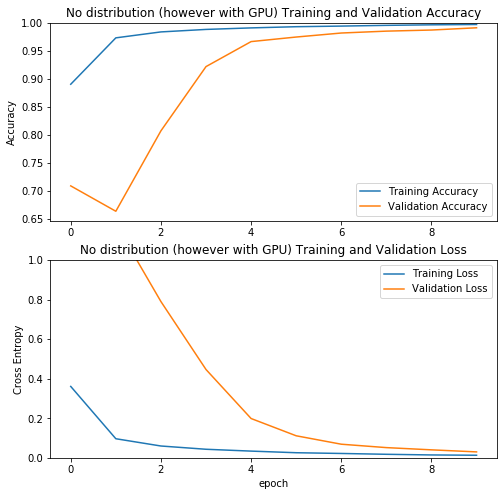

In [0]:
# As soon as a GPU is available, TensorFlow uses the GPU instead of the CPU
if len(list_gpu) > 0:
  gpu_model = create_model()

  fit_model_and_plot(gpu_model, train_batches, test_batches, STEPS_PER_EPOCH, VALIDATION_STEPS, "No distribution (however with GPU)")

### OneDevice strategy
Model is loaded only on a single device/processing unit that is specified. Best for testing purposes as only this resource will be used (see also [TensorFlow documentation](https://https://www.tensorflow.org/guide/distributed_training#onedevicestrategy)).

Train for 58 steps, validate for 9 steps
Epoch 1/10
58/58 [==============================] - 9s 151ms/step - loss: 0.3750 - accuracy: 0.8877 - val_loss: 1.4951 - val_accuracy: 0.5301
Epoch 2/10
58/58 [==============================] - 8s 132ms/step - loss: 0.0918 - accuracy: 0.9754 - val_loss: 1.5536 - val_accuracy: 0.3487
Epoch 3/10
58/58 [==============================] - 8s 131ms/step - loss: 0.0582 - accuracy: 0.9844 - val_loss: 1.0819 - val_accuracy: 0.5296
Epoch 4/10
58/58 [==============================] - 8s 132ms/step - loss: 0.0420 - accuracy: 0.9889 - val_loss: 0.4762 - val_accuracy: 0.8765
Epoch 5/10
58/58 [==============================] - 8s 132ms/step - loss: 0.0329 - accuracy: 0.9910 - val_loss: 0.2608 - val_accuracy: 0.9443
Epoch 6/10
58/58 [==============================] - 8s 130ms/step - loss: 0.0255 - accuracy: 0.9935 - val_loss: 0.1593 - val_accuracy: 0.9552
Epoch 7/10
58/58 [==============================] - 8s 131ms/step - loss: 0.0209 - accuracy: 0.9947 - val_l

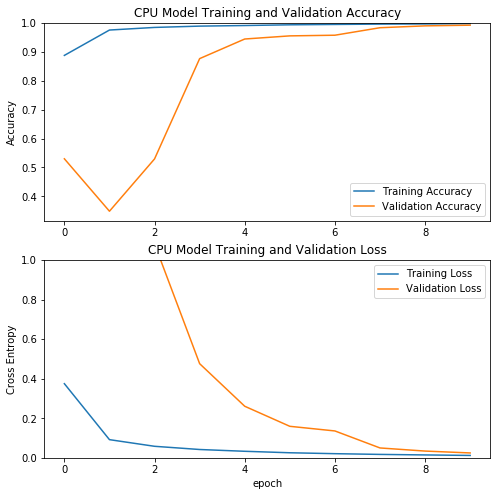

In [0]:
cpu_strategy = tf.distribute.OneDeviceStrategy(device="CPU:0")
with cpu_strategy.scope():
  cpu_model = create_model()

fit_model_and_plot(cpu_model, train_batches, test_batches, STEPS_PER_EPOCH, VALIDATION_STEPS, "CPU Model")

### TPU strategy
Model replicated among TPU cores/workers on one machine (see [here](https://https://www.tensorflow.org/guide/distributed_training#tpustrategy)). 

After training on batch of data, variables are updated via the [allreduce algorithm](https://https://towardsdatascience.com/visual-intuition-on-ring-allreduce-for-distributed-deep-learning-d1f34b4911da) across workers to keep them in sync. *(This approach is currently very similarly implemented in the Mirrored Strategy.)*
However, each processing unit trains on different batches (i.e. data parallelism).

Train for 58 steps, validate for 9 steps
Epoch 1/10
58/58 [==============================] - 6s 106ms/step - loss: 0.3815 - accuracy: 0.8873 - val_loss: 1.7325 - val_accuracy: 0.3619
Epoch 2/10
58/58 [==============================] - 1s 15ms/step - loss: 0.0918 - accuracy: 0.9751 - val_loss: 2.0667 - val_accuracy: 0.2650
Epoch 3/10
58/58 [==============================] - 1s 15ms/step - loss: 0.0572 - accuracy: 0.9845 - val_loss: 2.3920 - val_accuracy: 0.2534
Epoch 4/10
58/58 [==============================] - 1s 15ms/step - loss: 0.0430 - accuracy: 0.9884 - val_loss: 2.2010 - val_accuracy: 0.2931
Epoch 5/10
58/58 [==============================] - 1s 15ms/step - loss: 0.0334 - accuracy: 0.9910 - val_loss: 1.5666 - val_accuracy: 0.4544
Epoch 6/10
58/58 [==============================] - 1s 16ms/step - loss: 0.0263 - accuracy: 0.9930 - val_loss: 1.1790 - val_accuracy: 0.5803
Epoch 7/10
58/58 [==============================] - 1s 16ms/step - loss: 0.0217 - accuracy: 0.9947 - val_loss: 0

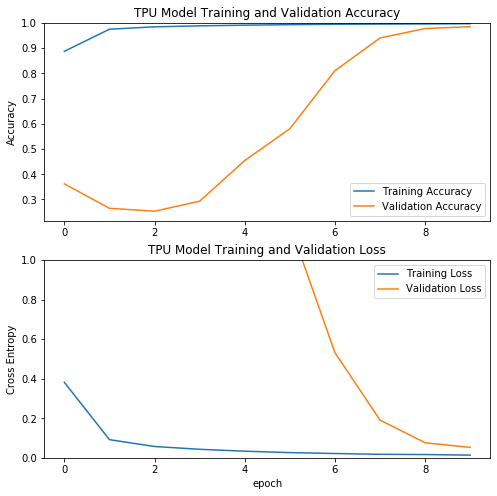

In [0]:
if 'tpu_strategy' in vars() or 'tpu_strategy' in globals():
  with tpu_strategy.scope():
    tpu_model = create_model()

  fit_model_and_plot(tpu_model, train_batches, test_batches, STEPS_PER_EPOCH, VALIDATION_STEPS, "TPU Model")

### Mirrored strategy
Models replicated among devices on one machine. After training, variables are updated to keep them in sync, however each processing unit trains on different batches. *(See [here](https://https://www.tensorflow.org/guide/distributed_training#mirroredstrategy) and also similarly implemented TPU strategy above.)*

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

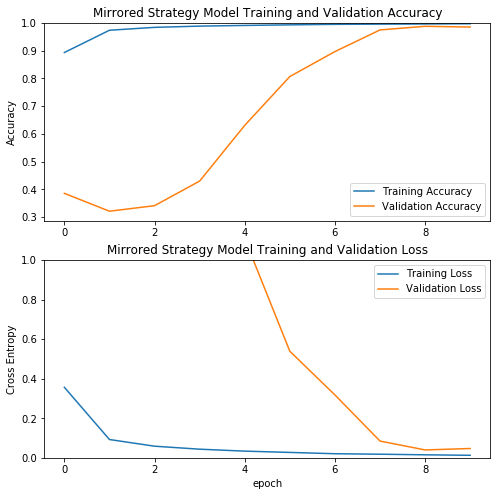

In [0]:
# not working with single CPU
if len(list_gpus) > 0:
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
    mirrored_model = create_model()

  fit_model_and_plot(mirrored_model, train_batches, test_batches, STEPS_PER_EPOCH, VALIDATION_STEPS, "Mirrored Strategy Model")

## Benchmarking 
Simply plot stored runtimes of different distribution strategies as part of benchmarking. 


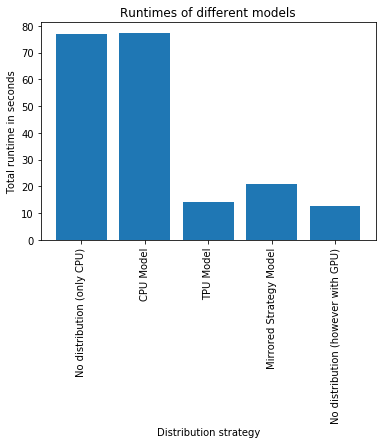

In [0]:
plt.bar(range(len(timings)), list(timings.values()), align='center')
plt.xticks(range(len(timings)), list(timings.keys()))
plt.title("Runtimes of different models")
plt.xlabel("Distribution strategy")
plt.xticks(rotation=90)
plt.ylabel("Total runtime in seconds")

plt.show()

## Additional remarks
There are a couple of further existing distribution strategies and more are likely to be implemented soon as described in the [TensorFlow guide on distributed training](https://www.tensorflow.org/guide/distributed_training#overview). 

It is important to note that a number of currently supported strategies for the Keras API are still experimental and might therefore be changed or removed.  

In [0]:
## Mirrored Strategy 
# Allows to restrict the distribution to a specific set of processing units
tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

## Multi Worker Mirrored Strategy
# Allows to scale the mirrored strategy to several workers with a central master
tf.distribute.experimental.MultiWorkerMirroredStrategy()

## Central Storage Strategy
# Model parameters will be saved on central unit and trained there 
# (e.g. all epochs on GPUs, model optimization on CPU, sending of gradients to central storage)
tf.distribute.experimental.CentralStorageStrategy()

## Parameter Server Strategy
# Scaled Central Storage Strategy, 
# i.e. several parameter servers which keep and update the parameters for worker models
tf.distribute.experimental.ParameterServerStrategy()